In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
import seaborn as snb

from jax import jit
from jax.scipy.stats import norm

from assignment3.utils import metropolis_multiple_chains, ess_single_chain_jax
from assignment3.exercise9 import compute_Rhat

from ex9.exercise9 import plot_summary

jax.config.update("jax_enable_x64", True)
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.)

pics_output_path = lambda filename: os.path.join('assignment3', 'img', filename) 

In [2]:
data = jnp.load(os.path.join('assignment3', 'data', 'data_assignment3.npz'))
X, y = data['x'], data['t']

# X = jnp.stack([X,jnp.ones_like(X)], axis=1)     
X = jnp.stack([jnp.ones_like(X), X], axis=1)

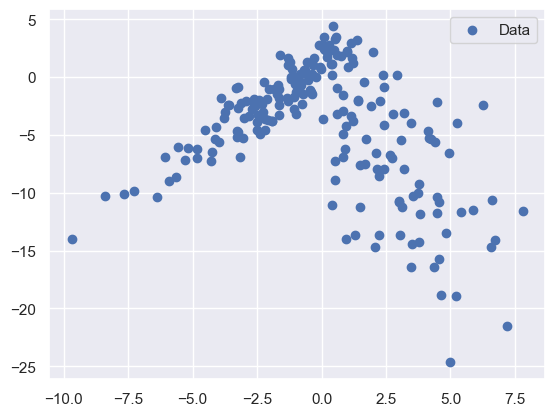

In [3]:
plt.scatter(X[:, 1], y, label='Data')
plt.legend()
plt.savefig(pics_output_path('part2-data.png'), dpi=300)

We model each $z_n$ using Bernoulli distributions as follows

$$
p(z_n \mid \pi_n) = \text{Ber}(z_n \mid \pi_n), \tag{3}
$$

where $\pi_n = \sigma(\mathbf{v}^\top \mathbf{x}_n)$ is the probability of $z_n = 1$, $\sigma(\cdot)$ is the logistic sigmoid function and $\mathbf{v}$ is a parameter vector to be estimated. That is, we basically model the latent $z_n$ variable using a logistic regression model.

We can set up a conditional likelihood as follows

$$
p(y_n \mid z_n, \mathbf{x}_n, \mathbf{w}_0, \mathbf{w}_1, \sigma_0^2, \sigma_1^2) = \begin{cases}
   \mathcal{N}(y_n \mid \mathbf{w}_1^\top \mathbf{x}_n, \sigma_1^2) &\text{if }  z_n = 1 \\
   \mathcal{N}(y_n \mid \mathbf{w}_0^\top \mathbf{x}_n, \sigma_0^2) &\text{if } z_n = 0
\end{cases}
$$


where we also allow the noise variance to depend on $z_n$. We complete the model with generic priors:

$$
\tau, \sigma_0^2, \sigma_1^2 \sim \mathcal{N}_+(0, 1) \tag{5}
$$

$$
\mathbf{w}_0, \mathbf{w}_1, \mathbf{v} \sim \mathcal{N}(0, \tau^2 \mathbf{I}) \tag{6}
$$

$$
z_n \mid \mathbf{v} \sim \text{Ber}(\sigma(\mathbf{v}^\top \mathbf{x}_n)) \tag{7}
$$

$$
y_n \mid z_n \sim \mathcal{N}(\mathbf{w}_{z_n}^\top \mathbf{x}_{n}, \sigma^2_{z_n}) \tag{8}
$$

where $\mathcal{N}_+(0, 1)$ is the half-normal distribution. This leads to a joint model of the form


$$
p(\mathbf{y}, \mathbf{w}_1, \mathbf{w}_0, \mathbf{v}, \mathbf{z}, \tau, \sigma_0, \sigma_1) = \left[
\prod_{n=1}^{N} 
\mathcal{N}\left(y_n \mid \mathbf{w}_{z_n}^T \mathbf{x}_n, \sigma_{z_n}^2\right)
\mathrm{Ber}\left(z_n \mid \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\right)
\right] 
\mathcal{N}(\mathbf{w}_0 \mid \mathbf{0}, \tau^2 \mathbf{I}) \\
\mathcal{N}(\mathbf{w}_1 \mid \mathbf{0}, \tau^2 \mathbf{I})
\mathcal{N}(\mathbf{v} \mid \mathbf{0}, \tau^2 \mathbf{I}) 
\mathcal{N}_{+}(\tau^2 \mid 0, 1)
\mathcal{N}_{+}(\sigma_0 \mid 0, 1)
\mathcal{N}_{+}(\sigma_1 \mid 0, 1).
$$


### Task 2.1: Marginalize out each $z_n$ from to joint model in eq. (9) to obtain a joint distribution, where the likelihood for each observation is a mixture of two Gaussian distributions

$$
p(\mathbf{y}, \mathbf{w}_1, \mathbf{w}_0, \mathbf{v}, \tau, \sigma_0, \sigma_1) = 
\mathcal{N}(\mathbf{w}_0 \mid \mathbf{0}, \tau^2 \mathbf{I})
\mathcal{N}(\mathbf{w}_1 \mid \mathbf{0}, \tau^2 \mathbf{I})
\mathcal{N}(\mathbf{v} \mid \mathbf{0}, \tau^2 \mathbf{I}) 
\mathcal{N}_{+}(\tau^2 \mid 0, 1)
\mathcal{N}_{+}(\sigma_0 \mid 0, 1)
\mathcal{N}_{+}(\sigma_1 \mid 0, 1)\\
\int \left[
\prod_{n=1}^{N} 
\mathcal{N}\left(y_n \mid \mathbf{w}_{z_n}^T \mathbf{x}_n, \sigma_{z_n}^2\right)
\mathrm{Ber}\left(z_n \mid \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\right)
\right] d\mathbf{z}
$$

For any n:

$$
\mathrm{Ber}\left(1 \mid \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\right) = \sigma\left(\mathbf{v}^T \mathbf{x}_n\right) \\
\mathrm{Ber}\left(0 \mid \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\right) = 1 - \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)
$$

Therefore:
$$
\int 
\mathcal{N}\left(y_n \mid \mathbf{w}_{z_n}^T \mathbf{x}_n, \sigma_{z_n}^2\right)
\mathrm{Ber}\left(z_n \mid \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\right)
dz_n =  \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\mathcal{N}\left(y_n \mid \mathbf{w}_{1}^T \mathbf{x}_n, \sigma_{1}^2\right) +  (1-\sigma\left(\mathbf{v}^T \mathbf{x}_n\right))\mathcal{N}\left(y_n \mid \mathbf{w}_{0}^T \mathbf{x}_n, \sigma_{0}^2\right)

$$

Finally:

$$
p(\mathbf{y}, \mathbf{w}_1, \mathbf{w}_0, \mathbf{v}, \tau, \sigma_0, \sigma_1) = 
\mathcal{N}(\mathbf{w}_0 \mid \mathbf{0}, \tau^2 \mathbf{I})
\mathcal{N}(\mathbf{w}_1 \mid \mathbf{0}, \tau^2 \mathbf{I})
\mathcal{N}(\mathbf{v} \mid \mathbf{0}, \tau^2 \mathbf{I}) 
\mathcal{N}_{+}(\tau^2 \mid 0, 1)
\mathcal{N}_{+}(\sigma_0 \mid 0, 1)
\mathcal{N}_{+}(\sigma_1 \mid 0, 1)\\
\prod_{n=1}^{N} \left[
 \sigma\left(\mathbf{v}^T \mathbf{x}_n\right)\mathcal{N}\left(y_n \mid \mathbf{w}_{1}^T \mathbf{x}_n, \sigma_{1}^2\right) +  (1-\sigma\left(\mathbf{v}^T \mathbf{x}_n\right))\mathcal{N}\left(y_n \mid \mathbf{w}_{0}^T \mathbf{x}_n, \sigma_{0}^2\right)
 \right]
$$

### Task 2.2: Implement a Python function to evaluate the marginalized log joint distribution

In [4]:
from jax.scipy.stats.multivariate_normal import logpdf as mvn_logpdf
from jax.nn import sigmoid
from jax import lax, vmap
from jax.scipy.special import logsumexp

@jit
def pack_params(w0, w1, v, tau, sigma0, sigma1):
    return jnp.concatenate([w0, w1, v, jnp.array([tau, sigma0, sigma1])])

@jit
def unpack_params(theta):
    w0, w1, v = theta[:6].reshape(3, 2)
    tau, sigma0, sigma1 = theta[6:]
    return w0, w1, v, tau, sigma0, sigma1

@jit
def log_halfnormal(x, scale = 1.0):
    return jnp.where(x >= 0,
                     jnp.log(2.0) + norm.logpdf(x, loc=0.0, scale=scale),
                     -jnp.inf)

@jit
def log_joint(data, theta):
    w0, w1, v, tau, sigma0, sigma1 = unpack_params(theta)

    # Log priors
    log_prior_mvn = lambda z: mvn_logpdf(z, jnp.zeros(z.shape[0]), (tau**2) * jnp.eye(z.shape[0]))

    log_priors = vmap(log_prior_mvn)(jnp.array([w0, w1, v])).sum() + \
        vmap(log_halfnormal)(jnp.array([tau**2, sigma0, sigma1])).sum()

    # Log-likelihood
    def log_likelihood_step(carry, xy):
        x, y = xy
        sigm = sigmoid(jnp.dot(v, x))     
        log_w1 = jnp.log(sigm) + norm.logpdf(y, loc=jnp.dot(w1, x), scale=sigma1)
        log_w0 = jnp.log(1 - sigm) + norm.logpdf(y, loc=jnp.dot(w0, x), scale=sigma0)
        return carry + logsumexp(jnp.stack([log_w1, log_w0]), axis=0), None

    log_likelihood, _ = lax.scan(log_likelihood_step, 0.0, data)
    return log_priors + log_likelihood

### Task 2.3: Run a Metropolis-Hasting sampler to infer all parameters. Explain the settings you used (number of iterations, proposal distribution etc)

In [5]:
w0, w1 = jnp.ones(2), jnp.ones(2)
v = jnp.ones(2)
tau = 0.5
sigma0 = 0.5
sigma1 = 0.5

In [6]:
num_chains = 1
num_iterations = 20000
num_params = 9

tau_cov = 0.1
theta_init = jnp.tile(pack_params(w0, w1, v, tau, sigma0, sigma1), (num_chains, 1))

thetas, _ = metropolis_multiple_chains(
    data = (X, y),
    log_target=log_joint,
    num_params=num_params,
    num_chains=num_chains,
    tau=tau_cov,
    num_iter=num_iterations,
    theta_init=theta_init,
    seeds=jnp.arange(num_chains)
)

In [7]:
warm_up = int(0.04 * num_iterations) 
thetas_after_warmup = thetas[:, warm_up:, :]

Rhats = compute_Rhat(thetas_after_warmup)
Seffs = ess_single_chain_jax(thetas_after_warmup.squeeze(0))

conv_diagnostic_str = lambda i: fr'$\hat{{R}}$={Rhats[i]:3.2f}, $S_{{eff}}$={Seffs[i]:3.2f}'

params = [
    (0, r'Parameter $\mathbf{w_0}$', fr'Trace of parameter $\mathbf{{w_0}}$, {conv_diagnostic_str(0)}, {conv_diagnostic_str(1)}'),
    (2, r'Parameter $\mathbf{w_1}$', fr'Trace of parameter $\mathbf{{w_1}}$, {conv_diagnostic_str(2)}, {conv_diagnostic_str(3)}'),
    (4, r'Parameter $\mathbf{v}$', fr'Trace of parameter $\mathbf{{v}}$, {conv_diagnostic_str(4)}, {conv_diagnostic_str(5)}'),
    
    (1, r'Parameter $\tau$', fr'Trace of parameter $\tau$, {conv_diagnostic_str(6)}'),
    (3, r'Parameter $\sigma_0$',fr'Trace of parameter $\sigma_0$, {conv_diagnostic_str(7)}'),
    (5, r'Parameter $\sigma_1$', fr'Trace of parameter $\sigma_1$, {conv_diagnostic_str(8)}')
]

print(f'Warm-up is: {warm_up}')

Warm-up is: 800


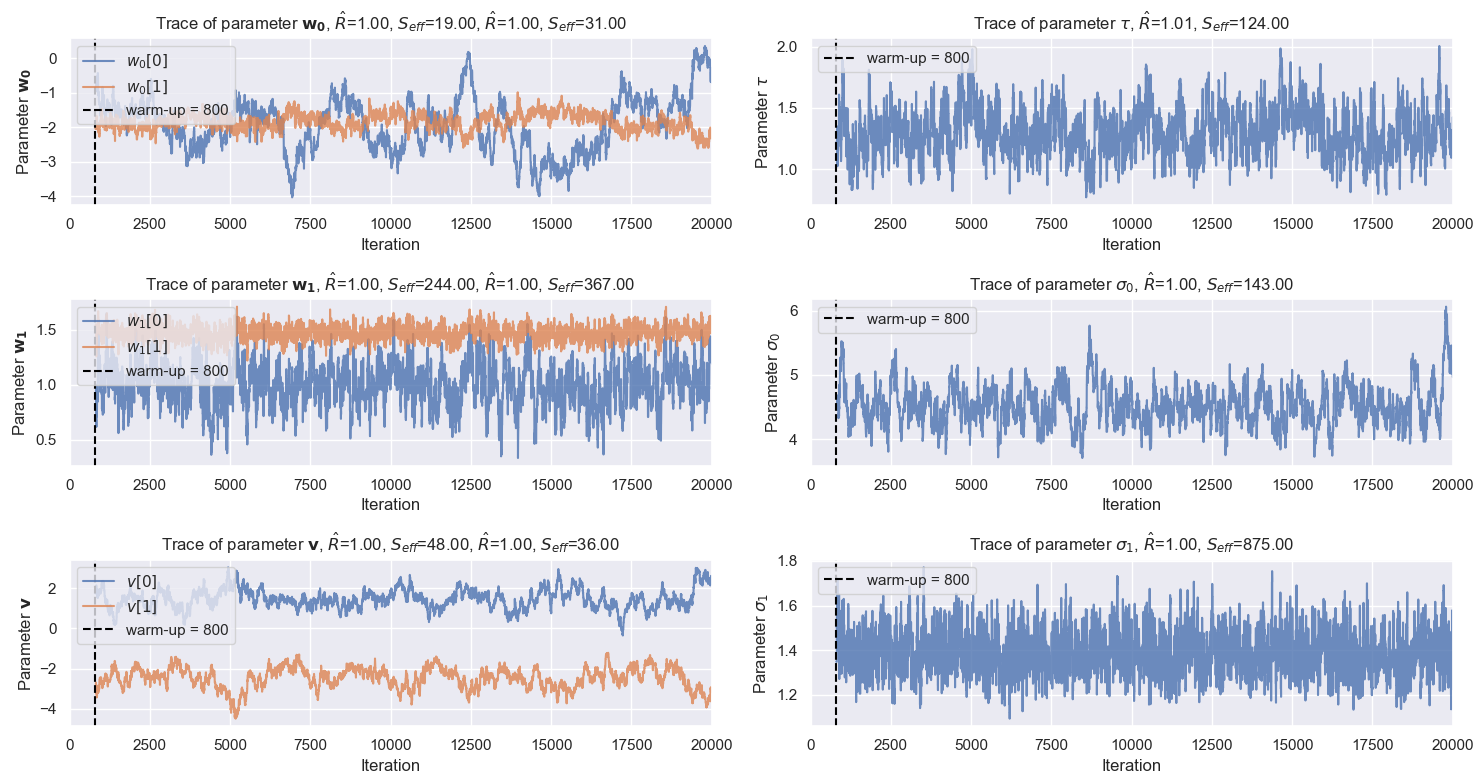

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes = axes.flatten()

thetas_after_warmup = thetas_after_warmup.reshape(num_iterations - warm_up + 1, num_params)

axes[0].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 0], alpha=0.8, label=r'$w_0[0]$')
axes[0].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 1], alpha=0.8, label=r'$w_0[1]$')

axes[2].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 2], alpha=0.8, label=r'$w_1[0]$')
axes[2].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 3], alpha=0.8, label=r'$w_1[1]$')

axes[4].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 4], alpha=0.8, label=r'$v[0]$')
axes[4].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 5], alpha=0.8, label=r'$v[1]$')

axes[1].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 6], alpha=0.8)
axes[3].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 7], alpha=0.8)
axes[5].plot(jnp.arange(warm_up, num_iterations+1), thetas_after_warmup[:, 8], alpha=0.8)


for i, ylabel, title in params:
    ax = axes[i]
    ax.axvline(warm_up, color='black', linestyle='--', label=f'warm-up = {warm_up}')
    ax.set_xlim(0, num_iterations)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='upper left')

fig.tight_layout()
plt.savefig(pics_output_path('img23.png'), dpi=300)
plt.show()

### Task 2.4: Report the posterior mean and 95% credibility intervals for all parameters.

In [9]:
import pandas as pd

post_mean = thetas_after_warmup.mean(axis=0)

param_names = [
    'w0[0]', 'w0[1]',
    'w1[0]', 'w1[1]',
    'v[0]',  'v[1]',
    'tau',
    'sigma0', 'sigma1'
]

df_ci = pd.DataFrame({
    'post mean': post_mean.round(2), 
    '2.5%': jnp.percentile(thetas_after_warmup, 2.5, axis=0).round(2),
    '97.5%': jnp.percentile(thetas_after_warmup, 97.5, axis=0).round(2)
}, index=param_names)

print(df_ci)

        post mean  2.5%  97.5%
w0[0]       -1.92 -3.44  -0.06
w0[1]       -1.85 -2.35  -1.41
w1[0]        1.00  0.61   1.38
w1[1]        1.48  1.35   1.61
v[0]         1.47  0.51   2.50
v[1]        -2.47 -3.58  -1.59
tau          1.30  0.92   1.70
sigma0       4.53  3.97   5.22
sigma1       1.39  1.22   1.59


### Task 2.5: For x ∈ [−12, 12], plot posterior predictive distribution for p(π∗|y, x∗), p(y∗|y, x∗, z∗ = 0) and p(y∗|y, x,z∗ = 1) on top of the data.

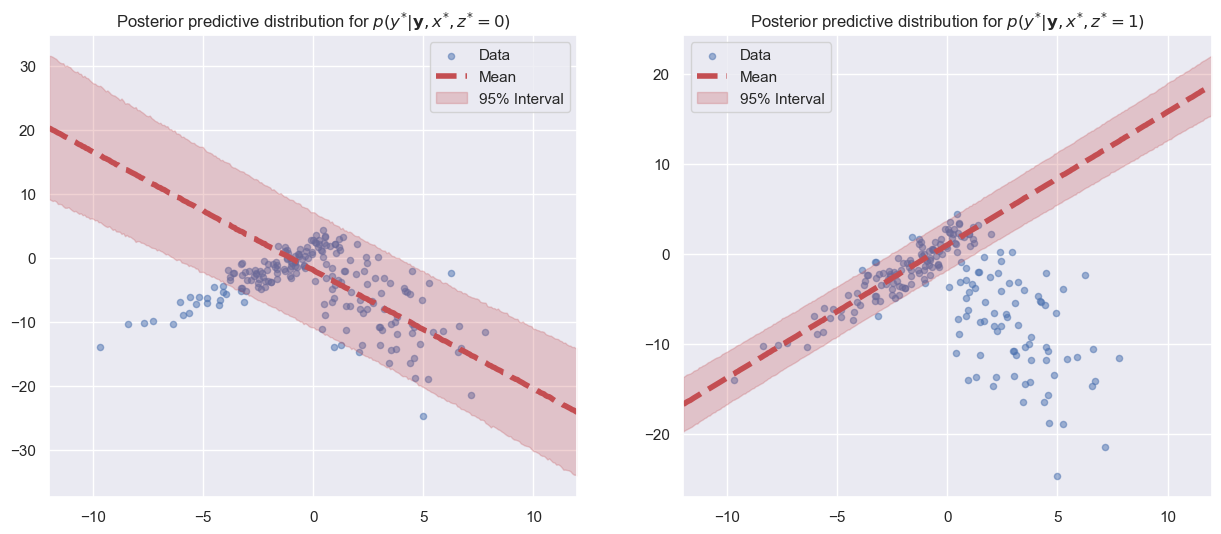

In [10]:
from jax import random

num_samples = thetas_after_warmup.shape[0]
# shape of w0, w1, v: (num_iterations - warm_up + 1, 2)
w0, w1, v, _, sigma0, sigma1 = vmap(unpack_params)(thetas_after_warmup)

Xstar = jnp.linspace(-12, 12, 300)
Xstar = jnp.column_stack([jnp.ones_like(Xstar), Xstar]) # [1, Xstar]

pi = sigmoid(v @ Xstar.T)

key, key0, key1, key2 = random.split(random.PRNGKey(0), 4)

# samples for each expert
y0_samp = w0 @ Xstar.T + sigma0[:, None] * random.normal(key=key0, shape=(num_samples, Xstar[:, 1].size))
y1_samp = w1 @ Xstar.T + sigma1[:, None] * random.normal(key=key1, shape=(num_samples, Xstar[:, 1].size))

# plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, y_expert in enumerate([y0_samp, y1_samp]):
    axes[i].scatter(X[:,1], y, alpha=0.5, s=20, label='Data')
    plot_summary(axes[i], Xstar[:, 1], y_expert)
    
axes[0].set(xlim=(-12, 12), title=r'Posterior predictive distribution for $p(y^{*}|\mathbf{y}, x^{*}, z^{*} = 0)$')
axes[1].set(xlim=(-12, 12), title=r'Posterior predictive distribution for $p(y^{*}|\mathbf{y}, x^{*}, z^{*} = 1)$')
plt.savefig(pics_output_path('img25.png'), dpi=300)

### Task 2.6: For x ∈ [−12, 12], plot posterior predictive distribution for $p(y^{*}|\mathbf{y}, x^{*})$

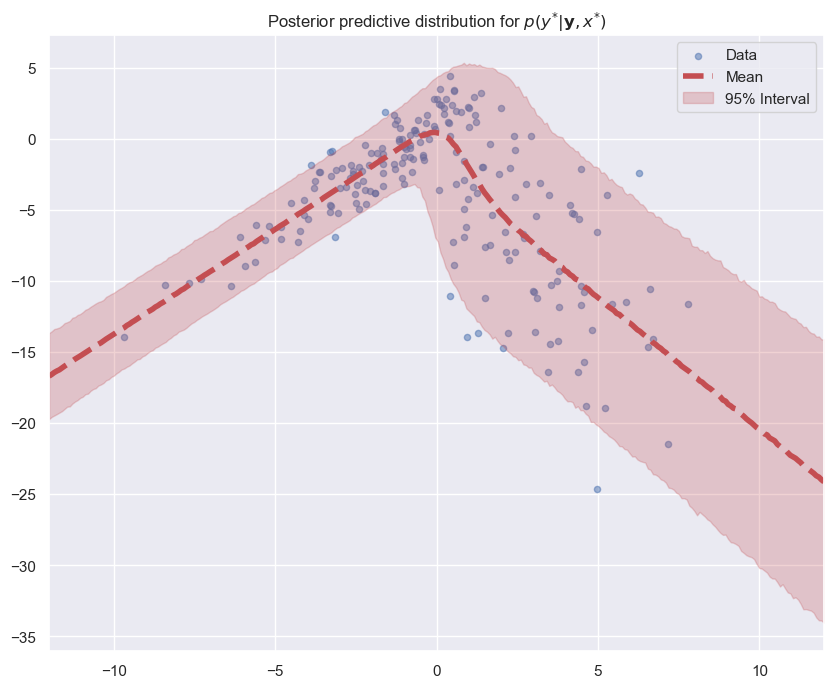

In [12]:
u = random.uniform(key2, (num_samples, Xstar[:, 1].size))
z = (u < pi).astype(float)
y_star = y0_samp * (1 - z) + y1_samp * z

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(X[:,1], y, alpha=0.5, s=20, label='Data')
ax.set(xlim=(-12, 12), title=r'Posterior predictive distribution for $p(y^{*}|\mathbf{y}, x^{*})$')
plot_summary(ax, Xstar[:, 1], y_star)
plt.savefig(pics_output_path('img26.png'), dpi=300)